In [1]:
from essentia.streaming import *
import essentia.standard as es
import essentia
import numpy as np
import matplotlib.pyplot as plt

In [2]:
windowing = es.Windowing(type='hann', normalized=False, zeroPadding=0)
spectrum = es.Spectrum()
melbands = es.MelBands(numberBands=48,
                               sampleRate=16000,
                               lowFrequencyBound=0,
                               highFrequencyBound=16000/2,
                               inputSize=(512+0)//2+1,
                               weighting='linear',
                               normalize='unit_tri',
                               warpingFormula='slaneyMel',
                               type='power')
amp2db = es.UnaryOperator(type='lin2db', scale=2)
oaudio = es.MonoLoader(filename='576923.mp3', sampleRate=16000)()
omelspec = []
for frame in es.FrameGenerator(oaudio, frameSize=512, hopSize=256, startFromZero=False):
    ospectrumFrame = spectrum(windowing(frame))
    omelFrame = melbands(ospectrumFrame)
    omelspec.append(amp2db(omelFrame))
omelspec = np.array(omelspec).T

In [3]:
import torch
import torchaudio
#Now reproduce with torchaudio
audio, fs = torchaudio.load('576923.mp3')

In [4]:
resample = torchaudio.transforms.Resample(orig_freq=fs, new_freq=16000)
meltrans = torchaudio.transforms.MelSpectrogram(sample_rate=16000, 
                                                n_fft=512, win_length=512, 
                                                hop_length=256, n_mels=48, 
                                                f_max=16000, norm='slaney')
a2db=torchaudio.transforms.AmplitudeToDB()

/home/enricguso/venvs/melon_venv/lib/python3.7/site-packages/torchaudio/functional/functional.py:358: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (48) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  "At least one mel filterbank has all zero values. "


In [5]:
audio=resample(audio).mean(0)

melspec=meltrans(audio)

melspec=a2db(melspec)

In [6]:
mel_melon = np.load('576923.npy')
melspec = melspec[:, 1250:-4]
rmse = np.sqrt(((melspec - mel_melon)**2).mean())
rmse

tensor(26.0483)

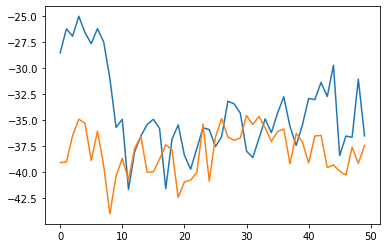

In [7]:
plt.plot(mel_melon[33,0:50])
plt.plot(melspec[33,0:50])